# Tabular Q-Learning

In [1]:
import humblerl as hrl
from humblerl import Callback, Mind
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Humble RL

Straightforward reinforcement learning Python framework. It provides all the boilerplate code needed to implement RL logic (see diagram below) for you.

![RL diagram](refs/rl_diagram.png)

## Frozen Lake

Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.

The surface is described using a grid like the following:
![Frozen Lake 8x8](refs/frozen_lake.png)
```
(S: starting point, safe)
(F: frozen surface, safe)
(H: hole, fall to your doom)
(G: goal, where the frisbee is located)
```
The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

## Mind

Think about the Mind as a brain of an Agent. It will tell the Agent what to do. It will observe what environment returns and decide what to do next. Your Mind needs to provide one method:

```python
def plan(self, state, train_mode, debug_mode):
    """Do forward pass through agent model (inference/planning) on state.

    Args:
        state (object): State of environment to inference on.
        train_mode (bool): Informs planner whether it's in training or evaluation mode.
            E.g. in evaluation it can optimise graph, disable exploration etc.
        debug_mode (bool): Informs planner whether it's in debug mode or not.

    Returns:
        np.array: Actions scores (e.g. unnormalized log probabilities/Q-values/etc.)
            possibly raw Artificial Neural Net output i.e. logits.
        object (optional): Mind's extra information, passed to 'on_action_planned' callback.
            If you will omit it, it will be set to None by default.
    """

    [...]
```

## Callback

Callbacks can be pluged into RL loop to listen to events that happend during each iteration:

```python
class Callback(metaclass=ABCMeta):
    """Callbacks can be used to listen to events during RL loop execution."""

    def on_loop_start(self):
        """Event when loop starts.

        Note:
            You can assume, that this event occurs before any other event in current loop.
        """

        pass

    def on_loop_end(self, is_aborted):
        """Event when loop finish.

        Args:
            is_aborted (bool): Flag indication if loop has finished as planed or was terminated.

        Note:
            You can assume, that this event occurs after specified episodes number or when
            loop is terminated manually (e.g. by Ctrl+C).
        """

        pass

    def on_episode_start(self, episode, train_mode):
        """Event when episode starts.

        Args:
            episode (int): Episode number.
            train_mode (bool): Informs whether episode is in training or evaluation mode.

        Note:
            You can assume, that this event occurs always before any action is taken in episode.
        """

        pass

    def on_episode_end(self, episode, train_mode):
        """Event after environment was reset.

        Args:
            episode (int): Episode number.
            train_mode (bool): Informs whether episode is in training or evaluation mode.

        Note:
            You can assume, that this event occurs after step to terminal state.
        """

        pass

    def on_action_planned(self, step, logits, info):
        """Event after Mind was evaluated.

        Args:
            step (int): Step number.
            logits (np.array): Actions scores (e.g. unnormalized log probabilities/Q-values/etc.)
                raw values returned from 'Mind.plan(...)'.
            info (object): Mind's extra information, may be None.

        Note:
            You can assume, that this event occurs always before step finish.
        """

        pass

    def on_step_taken(self, step, transition, info):
        """Event after action was taken in environment.

        Args:
            step (int): Step number.
            transition (Transition): Describes transition that took place.
            info (object): Environment diagnostic information if available otherwise None.

        Note:
            Transition is returned from `ply` function (look to docstring for more info).
            Also, you can assume, that this event occurs always after action was planned.
        """

        pass

    @property
    def metrics(self):
        """Returns execution metrics.

        Returns:
            dict: Dictionary with logs names and values.

        Note:
            Those values are fetched by 'humblerl.loop(...)' at the end of each episode (after
            'on_episode_end is' called) and then returned from 'humblerl.loop(...)' as evaluation
            history. Those also are logged by 'humblerl.loop(...)' depending on its verbosity.
        """

        return {}
```

![Frozen Lake 8x8](refs/q_learn.png)

In [2]:
class TabularQLearning(Mind, Callback):
    def __init__(self, nstates, nactions, learning_rate=0.9, decay_steps=300, discount_factor=0.95):
        # Store training parameters
        self._lr = learning_rate
        self._decay = decay_steps
        self._gamma = discount_factor
        self._episode_count = 1
        self._return = 0
        self.running_avg = [0]

        # Initialize Q-table
        self.Q = np.zeros((nstates, nactions), dtype=np.float)

    def plan(self, state, train_mode, debug_mode):
        # Decaying over time random noise for exploration
        random_noise = np.random.randn(self.Q.shape[1]) * (1. / self._episode_count)
        return self.Q[state] + random_noise

    def on_episode_start(self, episode, train_mode):
        self._return = 0

    def on_step_taken(self, step, transition, info):
        # Add reward to return
        self._return += transition.reward

        # Exponentially decaying learning rate
        LR = pow(self._lr, self._episode_count / self._decay)

        # Update Q-table
        if transition.is_terminal:
            target = transition.reward
        else:
            target = transition.reward + self._gamma * \
                np.max(self.Q[transition.next_state])
        self.Q[transition.state, transition.action] += \
            LR * (target - self.Q[transition.state, transition.action])

        # Count episodes
        if transition.is_terminal:
            self._episode_count += 1

    def on_episode_end(self, episode, train_mode):
        self.running_avg.append(0.01 * self._return + 0.99 * self.running_avg[-1])

    @property
    def metrics(self):
        return {"avg. return": self.running_avg[-1]}

In [3]:
# Hyper params
episodes = 865
lr = 0.75
decay = 400
gamma = 0.95

# Create environment and q-learning agent
env = hrl.create_gym("FrozenLake-v0")
mind = TabularQLearning(env.state_space, env.action_space.num,
                        learning_rate=lr, decay_steps=decay, discount_factor=gamma)

# Seed env and numpy
np.random.seed(7)
env.env.seed(7)

# Run training
_ = hrl.loop(env, mind, n_episodes=episodes, callbacks=[mind], verbose=1)

100%|##########| 865/865 [00:02<00:00, 294.79it/s, avg. return=0.785]  


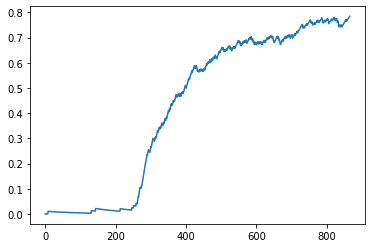

In [4]:
# Plot episodes lengths and returns
plt.plot(mind.running_avg, label="Returns")

![Frozen Lake 8x8](refs/frozen_lake.png)
### Actions:
* 0 - Left
* 1 - Down
* 2 - Right
* 3 - Up

In [5]:
np.argmax(mind.Q, axis=1).reshape(4,4)

array([[0, 3, 1, 3],
       [0, 0, 2, 0],
       [3, 1, 0, 0],
       [0, 2, 1, 0]])

Why is he going right in the (3,2) position?! Straight into the hole!!!